#### I got some cool Pandas and Python ideas from Jeffrey Estrada, Diana Doherty

In [1]:
from helpers import to_year, regionalize, convert_to_seconds, timeofday, us_states, convert_helper, proportions
import matplotlib.pyplot as pt
import pandas as pd
import numpy as np
import sklearn.datasets as datasets
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from dateutil import parser
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

pt.rcParams['figure.figsize'] = [5, 5]
data = pd.read_csv("all_ufos.csv")

In [2]:
states = us_states()
data = data.loc[data['State'].isin(states.values())]
data['Date / Time'].apply(str)
data['Time'] = data['Date / Time'].str.split(' ', 1).str[1]
data['Year'] = pd.to_datetime(data['Date / Time']).dt.date.apply(to_year)
data['Time'] = pd.to_datetime(data['Time']).dt.time
data['Region'] = data['State'].apply(regionalize)
data['Duration'] = data['Duration'].apply(str).apply(convert_to_seconds)

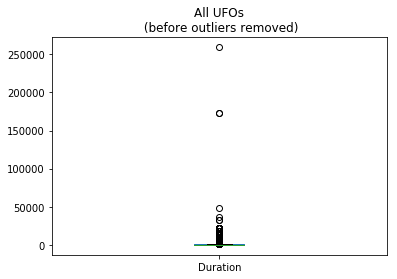

In [3]:
no_fliers = data['Duration'].plot.box(
    title = "All UFOs\n (before outliers removed)", 
    return_type='dict', whis=1.5)

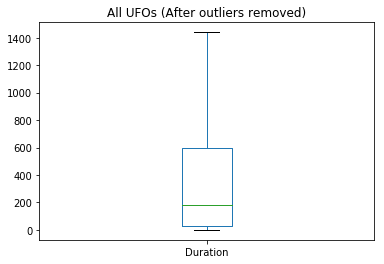

In [4]:
filtered_box = data['Duration'].plot.box(
    showfliers=False, title="All UFOs (After outliers removed)",
    return_type='dict', whis=1.5)

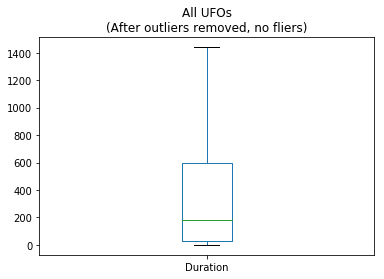

In [5]:
filtered_box = data['Duration'].plot.box(
    showfliers = False, title="All UFOs\n(After outliers removed, no fliers)",
    return_type='dict', whis=1.5)

The raw durations column is nonstandardized. 

To standardize the durations column into a uniform format, I used a regular 
expressions function that attempted to convert all the strings into seconds. 

Not all of the rows were caught by this function, but the majority were. 

Rows that could not be standardized are ignored.

In [6]:
circles = data.loc[data['Shape'] == 'Circle']
fireballs = data.loc[data['Shape'] == 'Fireball']
triangles = data.loc[data['Shape'] == 'Triangle']

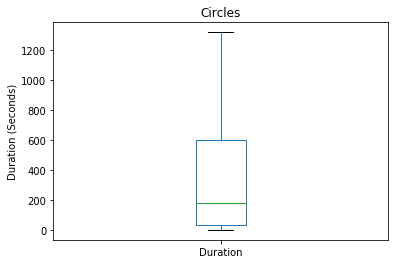

In [7]:
circle_bp = circles['Duration'].plot.box(
    showfliers = False, title="Circles")
circle_bp.set_ylabel("Duration (Seconds)")

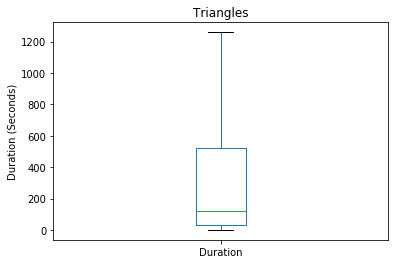

In [8]:
triangle_bp = triangles['Duration'].plot.box(
    showfliers = False, title = 'Triangles')
triangle_bp.set_ylabel("Duration (Seconds)")

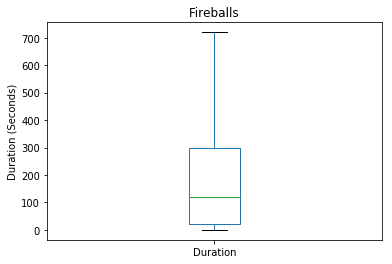

In [9]:
fireball_bp = fireballs['Duration'].plot.box(showfliers = False, title = 'Fireballs')
fireball_bp.set_ylabel("Duration (Seconds)")

In [10]:
fireball_years = fireballs.groupby(data['Year'])
circle_years = circles.groupby(data['Year'])
triangle_years = triangles.groupby(data['Year'])

In [11]:
pt.rcParams['figure.figsize'] = [15, 5]

fireball_years_df = fireball_years.size().reset_index(name="Counts")
circle_years_df = circle_years.size().reset_index(name="Counts")
triangle_years_df = triangle_years.size().reset_index(name="Counts")

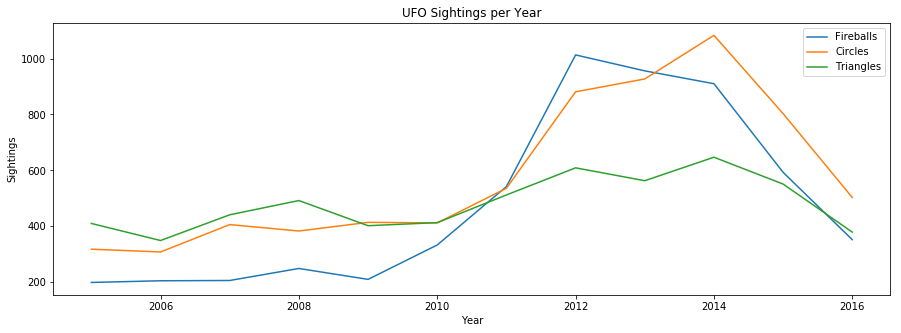

In [12]:
fig = pt.figure()

shapes = [fireball_years_df, circle_years_df, triangle_years_df]

for frame in shapes:
    pt.plot(frame['Year'], frame['Counts'])

pt.legend(['Fireballs', 'Circles', 'Triangles'])
pt.xlabel("Year")
pt.ylabel("Sightings")
pt.title("UFO Sightings per Year")
pt.show()

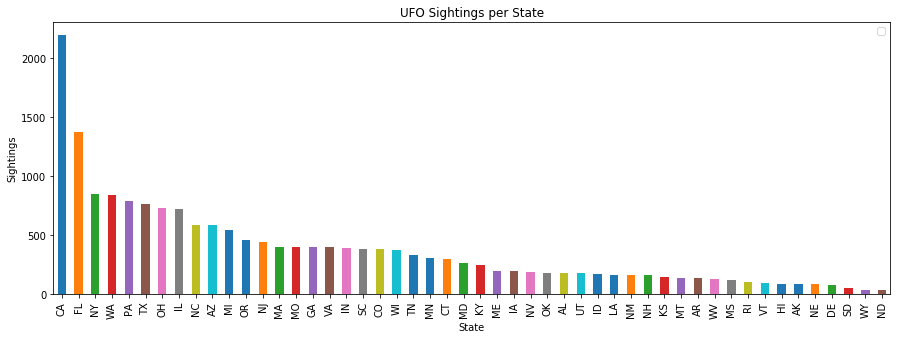

In [13]:
states = data.groupby(['State'])
states_df = states.size().reset_index(name='Counts')
states_df.sort_values(by='Counts', ascending=False).plot(
    kind = 'bar', x = 'State', y = 'Counts')
pt.legend("")
pt.ylabel("Sightings")
pt.title("UFO Sightings per State")

### Let's see if standardizing by US population percentage is interesting...

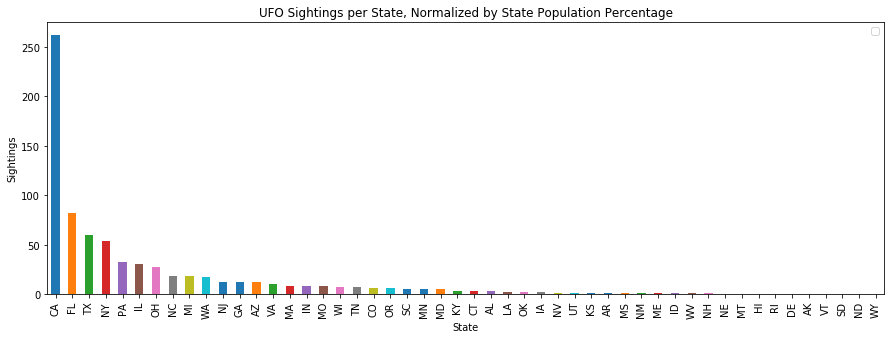

In [14]:
state_proportions = proportions()
def normalize(row):
    state = row[0]
    proportion = state_proportions[state]
    return row[1] * proportion * 0.01

states_df['Normalized'] = states_df.apply(normalize, axis=1)

states_df.sort_values(by='Normalized', ascending=False).plot(
    kind = 'bar', x = 'State', y = 'Normalized')
pt.legend("")
pt.ylabel("Sightings")
pt.title("UFO Sightings per State, Normalized by State Population Percentage")

### Let's see if grouping by region is interesting...

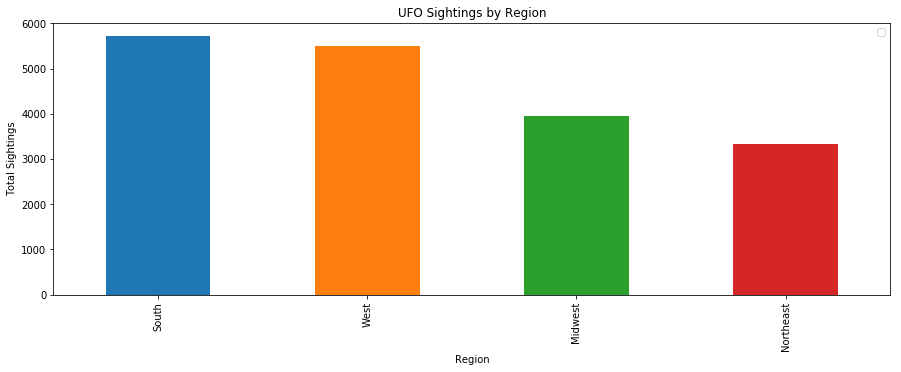

In [15]:
regions = data.groupby(['Region'])
regions_df = regions.size().reset_index(name='Counts')
regions_df.sort_values(by='Counts', ascending=False).plot(
    kind = 'bar', x = 'Region', y = 'Counts')
pt.legend("")
pt.ylabel("Total Sightings")
pt.title("UFO Sightings by Region")

Obtained state population percentages from:
http://www.statemaster.com/red/graph/peo_per_of_tot_pop-people-percent-of-total-population&b_printable=1

### How about standardized regions

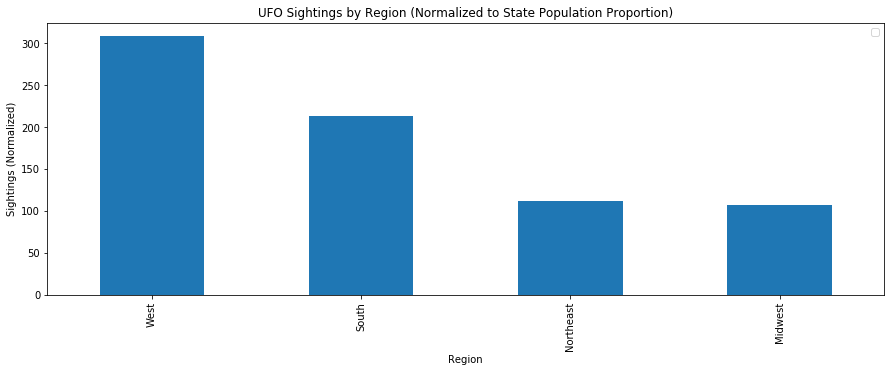

In [16]:
states_df['Region'] = states_df['State'].apply(regionalize)

regions_df = states_df[['Region', 'Normalized']]
regions_df
normalized_regions = regions_df.groupby('Region')['Normalized'].sum()
normalized_regions_df = pd.DataFrame(normalized_regions)
normalized_regions_df.sort_values(by='Normalized', ascending=False).plot(kind = 'bar')

pt.legend("")
pt.ylabel("Sightings (Normalized)")
pt.title("UFO Sightings by Region (Normalized to State Population Proportion)")

# Task 2

In [17]:
prediction_data = data[data['Time'].notnull()]
prediction_data.Time = prediction_data['Time'].apply(timeofday)


/usr/local/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### The original decision tree

In [18]:
training = prediction_data[prediction_data['Year'] >= 2014]

dtree=DecisionTreeClassifier()

training_samples = pd.get_dummies(training[['Time','Region']])
training_labels = training['Shape']

dtree.fit(training_samples, training_labels)

test = prediction_data[prediction_data['Year'] < 2014]
test_samples = pd.get_dummies(test[['Time','Region']])
test_labels = test['Shape']

print("Initial accuracy:", 
      dtree.score(test_samples, test_labels) * 100, "%")

Initial accuracy: 36.3593118211 %


Decision Tree Visualization


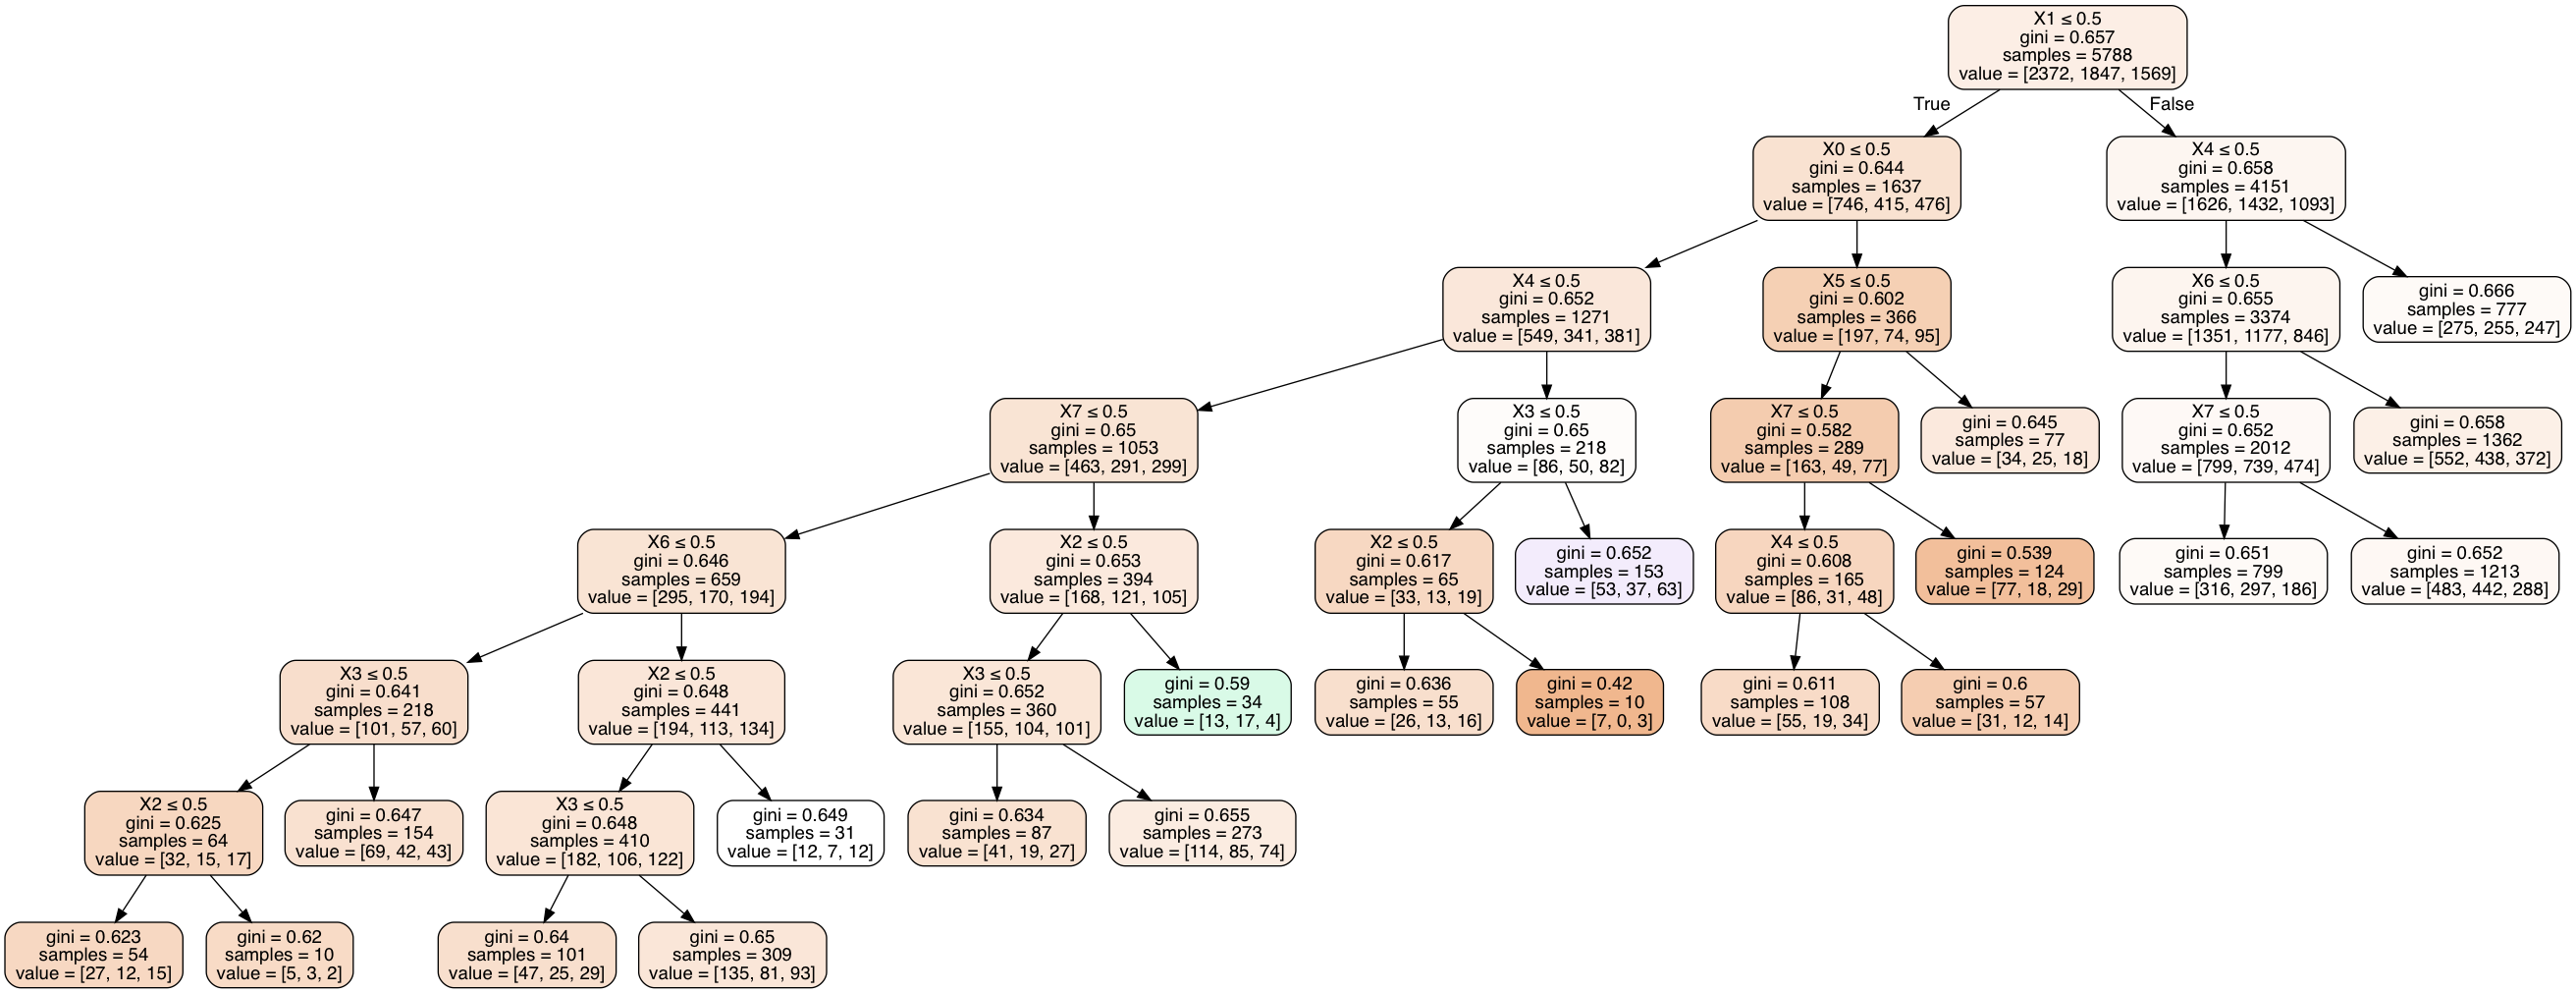

In [19]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
print("Decision Tree Visualization")
Image(graph.create_png())

### Using sklearn library to attempt accuracy improvement

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(prediction_data[['Time','Region']]),
    prediction_data['Shape'], random_state=1)

model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print("Moderately Improved accuracy", 
      accuracy_score(y_test, y_predict) * 100, "%")

Moderately Improved accuracy 37.8396000869 %
